In [23]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
animal = 'GRB006'  # example animal
session = '20240814_154434'  # example session

data_dir = '/Volumes/grb_ephys/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

In [155]:
pop_peth, timebin_edges, _ = population_peth(
        all_spike_times=spike_times_per_unit,
        alignment_times=np.hstack(trial_ts.first_stim_ts),
        pre_seconds=0,
        post_seconds=0.150,
        binwidth_ms=10,
        pad=0,
        kernel=None,
    )

n_units, n_stims, n_timepoints = pop_peth.shape

Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from input array
Discarding 19 NaNs from inpu

In [156]:
n_units, n_stims, n_timepoints = pop_peth.shape

y = pop_peth.reshape(n_units, n_stims*n_timepoints)

#sklearn expects time to be the first dimension
y = y.T
X = np.tile(np.eye(n_timepoints), (n_stims, 1))

print(X.shape, y.shape)
assert y.shape[0] == X.shape[0]

(5759, 13) (5759, 182)


In [170]:
#let's implement some cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model = LinearRegression()
cv = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(scores.mean())

model.fit(X, y)

0.013678781315821892


LinearRegression()

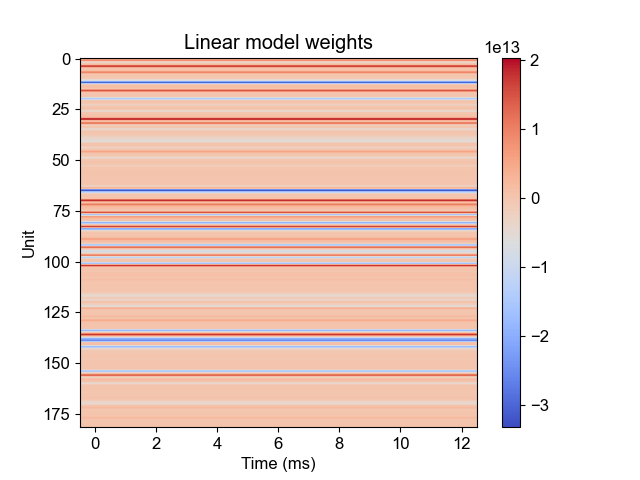

In [171]:
plt.figure()
plt.imshow(model.coef_, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Unit')
plt.title('Linear model weights')
plt.show()

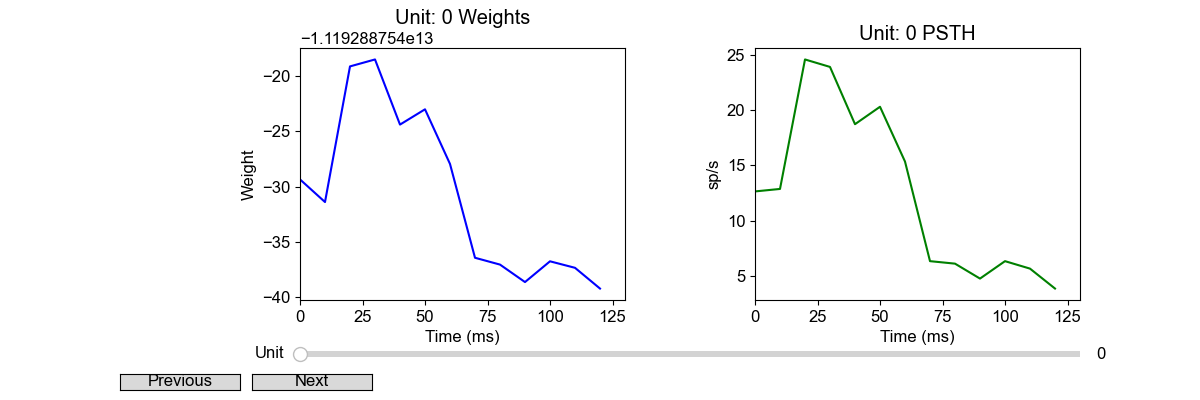

In [182]:
# I want to make an interactive line plot of a unit's weight across time
# and also plot the PSTH for each unit to compare the weights with the actual activity

from matplotlib.widgets import Slider, Button
fig, (ax_weights, ax_psth) = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.25, bottom=0.25, wspace=0.4)
axcolor = 'lightgoldenrodyellow'
axunit = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
sunit = Slider(axunit, 'Unit', 0, n_units-1, valinit=0, valstep=1)

# Add buttons for navigating units
axprev = plt.axes([0.1, 0.025, 0.1, 0.04])
axnext = plt.axes([0.21, 0.025, 0.1, 0.04])
bprev = Button(axprev, 'Previous')
bnext = Button(axnext, 'Next')

def update(val):
    unit = int(sunit.val)
    ax_weights.clear()
    ax_weights.plot(np.arange(0, 130, 10), model.coef_[unit, :], color='blue')
    ax_weights.set_xlabel('Time (ms)')
    ax_weights.set_ylabel('Weight')
    ax_weights.set_title(f'Unit: {unit} Weights')
    ax_weights.set_xlim(0, 130)

    ax_psth.clear()
    ax_psth.plot(np.arange(0, 130, 10), np.mean(pop_peth[unit, :, :], axis=0), color='green')
    ax_psth.set_xlabel('Time (ms)')
    ax_psth.set_ylabel('sp/s')
    ax_psth.set_title(f'Unit: {unit} PSTH')
    ax_psth.set_xlim(0, 130)

    plt.draw()

def prev(event):
    current_val = sunit.val
    if current_val > 0:
        sunit.set_val(current_val - 1)

def next(event):
    current_val = sunit.val
    if current_val < n_units - 1:
        sunit.set_val(current_val + 1)

sunit.on_changed(update)
bprev.on_clicked(prev)
bnext.on_clicked(next)
update(0)  # Initial plot
plt.show()
